In [ ]:
!nvidia-smi

Sat Apr 12 11:03:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!apt-get update
!apt-get install -y libopencv-dev python3-opencv pkg-config
!nvcc --version

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 129 kB in 1s (90.8 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Don

In [ ]:
!pkg-config --cflags --libs opencv4

-I/usr/include/opencv4 -lopencv_stitching -lopencv_alphamat -lopencv_aruco -lopencv_barcode -lopencv_bgsegm -lopencv_bioinspired -lopencv_ccalib -lopencv_dnn_objdetect -lopencv_dnn_superres -lopencv_dpm -lopencv_face -lopencv_freetype -lopencv_fuzzy -lopencv_hdf -lopencv_hfs -lopencv_img_hash -lopencv_intensity_transform -lopencv_line_descriptor -lopencv_mcc -lopencv_quality -lopencv_rapid -lopencv_reg -lopencv_rgbd -lopencv_saliency -lopencv_shape -lopencv_stereo -lopencv_structured_light -lopencv_phase_unwrapping -lopencv_superres -lopencv_optflow -lopencv_surface_matching -lopencv_tracking -lopencv_highgui -lopencv_datasets -lopencv_text -lopencv_plot -lopencv_ml -lopencv_videostab -lopencv_videoio -lopencv_viz -lopencv_wechat_qrcode -lopencv_ximgproc -lopencv_video -lopencv_xobjdetect -lopencv_objdetect -lopencv_calib3d -lopencv_imgcodecs -lopencv_features2d -lopencv_dnn -lopencv_flann -lopencv_xphoto -lopencv_photo -lopencv_imgproc -lopencv_core


In [15]:
# Step 1: Write CUDA code to a file
code = r'''
#include <iostream>
#include <chrono>
#include <fstream>
#include <cuda_runtime.h>
#include <cstdlib>
#include <ctime>
#include <opencv2/opencv.hpp>

//------------------------------------------------------------------------------------
// GPU Kernel for RGB-to-grayscale conversion using given weights: 0.3, 0.6, 0.1
//------------------------------------------------------------------------------------
__global__ void rgb2GreyKernel(unsigned char* red, unsigned char* green, unsigned char* blue,
                               unsigned int width, unsigned int height, unsigned char* grey) {
    unsigned int row = blockIdx.y * blockDim.y + threadIdx.y;
    unsigned int column = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < height && column < width) {
        unsigned int i = row * width + column;
        grey[i] = red[i] * 3 / 10 + green[i] * 6 / 10 + blue[i] * 1 / 10;
    }
}

//------------------------------------------------------------------------------------
// GPU version: Allocate device memory, copy data, run kernel, and copy back result.
// The function also measures the kernel execution time using CUDA events.
//------------------------------------------------------------------------------------
float rgb2GreyGPU(unsigned char* red_h, unsigned char* green_h, unsigned char* blue_h,
                   unsigned char* grey_h, unsigned int width, unsigned int height) {

    unsigned char *red_D, *green_D, *blue_D, *grey_D;
    int size = width * height * sizeof(unsigned char);

    // Allocate device memory
    cudaMalloc((void **)&red_D, size);
    cudaMalloc((void **)&green_D, size);
    cudaMalloc((void **)&blue_D, size);
    cudaMalloc((void **)&grey_D, size);

    // Copy data from host to device
    cudaMemcpy(red_D, red_h, size, cudaMemcpyHostToDevice);
    cudaMemcpy(green_D, green_h, size, cudaMemcpyHostToDevice);
    cudaMemcpy(blue_D, blue_h, size, cudaMemcpyHostToDevice);

    // Set up CUDA events for timing
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    // Define block and grid dimensions
    dim3 numThreadsPerBlock(32, 32);
    dim3 numBlocks((width + numThreadsPerBlock.x - 1) / numThreadsPerBlock.x,
                   (height + numThreadsPerBlock.y - 1) / numThreadsPerBlock.y);

    // Start GPU timer
    cudaEventRecord(start);
    rgb2GreyKernel<<<numBlocks, numThreadsPerBlock>>>(red_D, green_D, blue_D, width, height, grey_D);
    cudaEventRecord(stop);

    // Wait for the kernel to complete
    cudaDeviceSynchronize();

    // Calculate elapsed time on GPU (in milliseconds)
    float gpuTime = 0;
    cudaEventElapsedTime(&gpuTime, start, stop);

    // Copy the result back to host
    cudaMemcpy(grey_h, grey_D, size, cudaMemcpyDeviceToHost);

    // Clean up GPU memory
    cudaFree(red_D);
    cudaFree(green_D);
    cudaFree(blue_D);
    cudaFree(grey_D);
    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    return gpuTime; // in ms
}

//------------------------------------------------------------------------------------
// CPU version: Convert RGB image to grayscale using the same weights.
// This version uses a simple loop and is timed using std::chrono.
//------------------------------------------------------------------------------------
double rgb2GreyCPU(unsigned char* red, unsigned char* green, unsigned char* blue,
                   unsigned char* grey, unsigned int width, unsigned int height) {
    auto start = std::chrono::high_resolution_clock::now();
    for (unsigned int i = 0; i < width * height; i++) {
        // Compute grayscale using integer math with the same weights
        grey[i] = red[i] * 3 / 10 + green[i] * 6 / 10 + blue[i] * 1 / 10;
    }
    auto end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double, std::milli> elapsed = end - start;
    return elapsed.count(); // milliseconds
}

//------------------------------------------------------------------------------------
// Main: Loads image, splits the channels, runs GPU and CPU conversion,
// and saves the resulting images along with printing performance timings.
//------------------------------------------------------------------------------------
int main() {
    // Print GPU information
    cudaDeviceProp deviceProp;
    cudaGetDeviceProperties(&deviceProp, 0);
    std::cout << "GPU: " << deviceProp.name << "\n";
    std::cout << "Compute Capability: " << deviceProp.major << "." << deviceProp.minor << "\n";

    // Load the image using OpenCV (make sure the image "file.jpg" exists in the working dir)
    cv::Mat image = cv::imread("file.jpg");
    if (image.empty()) {
        std::cerr << "Error: Image not found.\n";
        return -1;
    }

    // Ensure the image is in 8-bit 3 channel format
    if (image.channels() != 3) {
        std::cerr << "Error: Expected a 3-channel image.\n";
        return -1;
    }

    // Get image dimensions
    unsigned int width = image.cols;
    unsigned int height = image.rows;

    // Split channels from the source image
    std::vector<cv::Mat> channels(3);
    cv::split(image, channels);
    unsigned char *red   = channels[2].data;
    unsigned char *green = channels[1].data;
    unsigned char *blue  = channels[0].data;

    // Prepare output buffers for GPU and CPU results (each is an array of size width*height)
    std::vector<unsigned char> grey_gpu(width * height);
    std::vector<unsigned char> grey_cpu(width * height);

    // Run GPU conversion and record its time
    float gpuTime = rgb2GreyGPU(red, green, blue, grey_gpu.data(), width, height);
    std::cout << "GPU conversion time: " << gpuTime << " ms\n";

    // Run CPU conversion and record its time
    double cpuTime = rgb2GreyCPU(red, green, blue, grey_cpu.data(), width, height);
    std::cout << "CPU conversion time: " << cpuTime << " ms\n";

    // Create output images from the results and save them
    cv::Mat grey_image_gpu(height, width, CV_8UC1, grey_gpu.data());
    cv::Mat grey_image_cpu(height, width, CV_8UC1, grey_cpu.data());
    cv::imwrite("gray_output_gpu.jpg", grey_image_gpu);
    cv::imwrite("gray_output_cpu.jpg", grey_image_cpu);

    std::cout << "Grayscale images saved: 'gray_output_gpu.jpg' and 'gray_output_cpu.jpg'\n";

    return 0;
}


'''

# Step 2: Save to file
with open('script.cu', 'w') as f:
    f.write(code)

# Step 3: Compile using nvcc
# Ref: https://stackoverflow.com/questions/73361454/i-am-getting-zeros-as-a-result-of-vector-additon-in-cuda-and-no-errors
!nvcc -arch=sm_75 script.cu -o script `pkg-config --cflags --libs opencv4`

# Step 4: Run the binary
!./script


/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

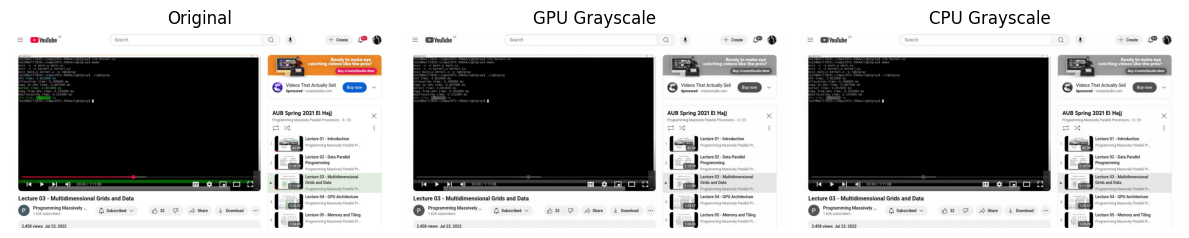

In [18]:
import cv2
from matplotlib import pyplot as plt

# Load the images that were saved by your C++ code
gray_gpu = cv2.imread("gray_output_gpu.jpg", cv2.IMREAD_GRAYSCALE)
gray_cpu = cv2.imread("gray_output_cpu.jpg", cv2.IMREAD_GRAYSCALE)

original = cv2.imread("file.jpg")
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)  # convert BGR to RGB for correct colors

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(original)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(gray_gpu, cmap='gray')
plt.title("GPU Grayscale")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(gray_cpu, cmap='gray')
plt.title("CPU Grayscale")
plt.axis('off')

plt.tight_layout()
plt.show()

